In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import os
from scipy.stats import entropy
%matplotlib inline

os.chdir("..")
total_df = pd.read_pickle('total_df.pckl.gz', compression = 'gzip')

In [2]:
from scipy.stats import ks_2samp
from scipy.stats import entropy

def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [3]:
cols = list(total_df.columns)
gender_cols = [i for i in cols if i.startswith('gender')]
race_cols = [i for i in cols if i.startswith('race')]
print(gender_cols)
print(race_cols)

['gender_female', 'gender_male', 'gender_unknown']
['race_albino', 'race_american indian', 'race_asian', 'race_biracial', 'race_black', 'race_hispanic', 'race_unknown', 'race_white', 'race_white [hispanic or latino]', 'race_white/black [hispanic or latino]']


In [4]:
def is_binary(series, allow_na=False):
    '''
    Helper function for check_allcols_are_binary
    '''

    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]


def check_allcols_are_binary(df, start_string):
    ''' 
    Takes a OHE df and a string and checks if all columns starting with 
    that string are binary. If all columns are binary it returns the list of
    all column names, otherwise it returns a list of non_binary_cols.
    
    df: dataframe containing the OHE columns and data
    start_string: string that the OHE columns starts with (i.e. 'gender') 
    would return OHE columns ['gender_female', 'gender_male', 'gender_unknown']
    '''
    
    col_selection = [i for i in list(df.columns) if i.startswith(start_string)]
    non_binary_cols = []
    for column in col_selection:
        if is_binary(df[column]) != True:
            non_binary_cols.append(column)
    if non_binary_cols == []:
        print('All columns binary, returning complete column list')
        return col_selection
    else:
        print('Some columns not binary, returning list of non-binary columns')
        return non_binary_cols

In [5]:
# inpso from: https://stackoverflow.com/questions/38334296/reversing-
# one-hot-encoding-in-pandas
def undo_ohe_cols(df, col_subset):
    ''' 
    Takes a OHE df and a list of BINARY columns and undoes the OHE of those
    columns, returning a single series with original values in it.
    
    df: dataframe containing the OHE columns and data 
    col_subset: list of binary OHE columns on which you want to undo OHE
    '''

    df_subset = df[df.columns & col_subset]
    def undo_binary(row):
        for c in df_subset.columns:
            if row[c]==1:
                return c
    single_col = df_subset.apply(undo_binary, axis=1)
    return single_col

In [6]:
# check all cols are binary
race_cols = check_allcols_are_binary(total_df, 'race')

# since all binday, can undo-OHE
single_race_col = undo_ohe_cols(total_df, race_cols)

single_race_col.head()

All columns binary, returning complete column list


case_participant_id
260122253823                         race_black
272161011760                         race_black
864286527653                      race_hispanic
882206007016                         race_black
882242005211    race_white [hispanic or latino]
dtype: object

In [7]:
# check all cols are binary
gender_cols = check_allcols_are_binary(total_df, 'gender')

# since all binday, can undo-OHE
single_gender_col = undo_ohe_cols(total_df, gender_cols)

All columns binary, returning complete column list


### Looking at the distribution of charge_count in the whole population vs in sub-populations (by race). Here charge_count is already a numeric feature, so we don't have to undo one hot encoding. Seems like there could be some higher charge_counts for american indian and biracial, but these are small sample sizes.

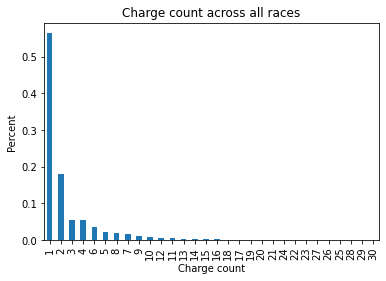

In [8]:
# all races
len(total_df['charge_count'].unique())
val_counts = total_df['charge_count'].value_counts(normalize=
                                                   True).nlargest(30).plot(kind='bar')
plt.ylabel('Percent')
plt.xlabel('Charge count')
plt.title('Charge count across all races')

top20allraces = list(total_df['charge_count'].value_counts().nlargest(20).index)

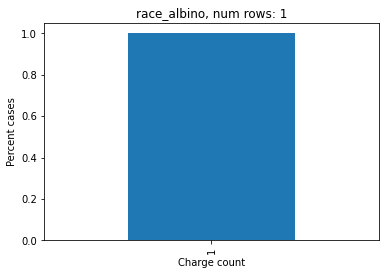

ks_test:  0.4353705023279625
items in top 10 for this race that are not in top 20 items for all races:  set()


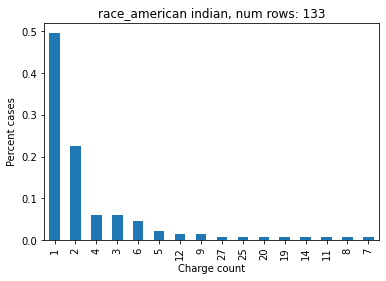

ks_test:  0.06838889616827815
items in top 10 for this race that are not in top 20 items for all races:  {25, 27}


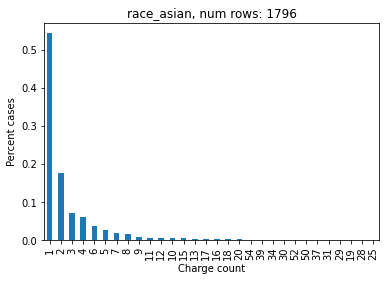

ks_test:  0.025920746518387272
items in top 10 for this race that are not in top 20 items for all races:  set()


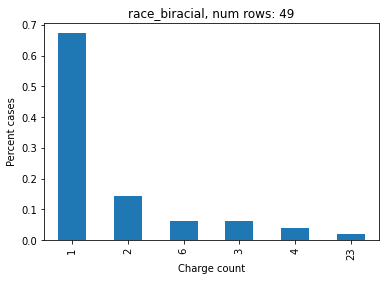

ks_test:  0.1088398900830645
items in top 10 for this race that are not in top 20 items for all races:  {23}


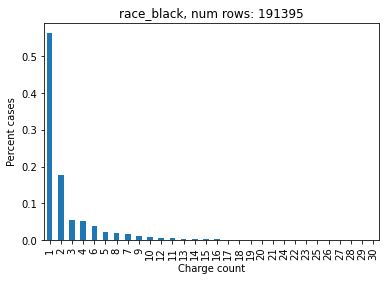

ks_test:  0.006214021903543809
items in top 10 for this race that are not in top 20 items for all races:  set()


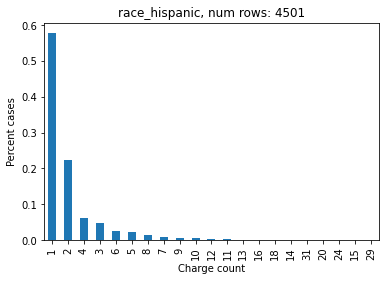

ks_test:  0.056505318647922076
items in top 10 for this race that are not in top 20 items for all races:  set()


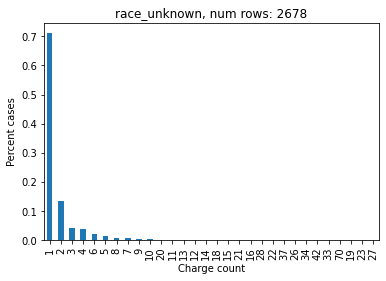

ks_test:  0.1470956703638101
items in top 10 for this race that are not in top 20 items for all races:  set()


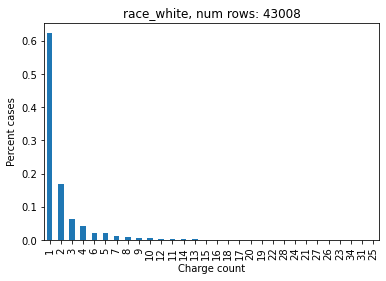

ks_test:  0.058766149649391086
items in top 10 for this race that are not in top 20 items for all races:  set()


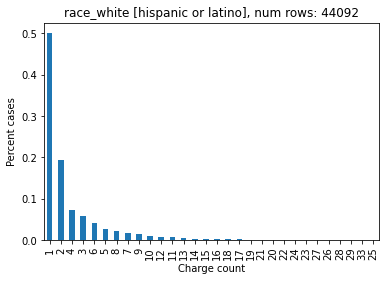

ks_test:  0.06399446183787261
items in top 10 for this race that are not in top 20 items for all races:  set()


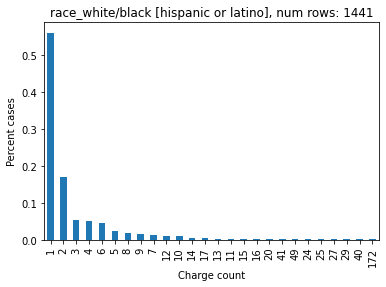

ks_test:  0.017384638169911093
items in top 10 for this race that are not in top 20 items for all races:  set()


In [10]:
# looking at distributions for each race 
for col in race_cols:
    race_df = total_df[total_df[col] == 1]
    val_counts = race_df['charge_count'].value_counts(normalize=True).nlargest(30).plot(kind='bar')
    title = str(col) + ', num rows: ' + str(len(race_df))
    plt.xlabel('Charge count')
    plt.title(title)
    plt.ylabel('Percent cases')
    plt.show()
    print('ks_test: ', ks_test(total_df, race_df, 'charge_count'))
    
    # print chg counts in top 10 that are not in top 20 across all races
    top10 = race_df['charge_count'].value_counts(normalize=True).nlargest(10).index
    print('items in top 10 for this race that are not in top 20 items for all races: ',
          set(top10) - set(top20allraces))

### Repeating same process but looking at offense_category distributions. Note, this (and all following colums were OHE so we have to undo the OHE first). We don't see any real differences across total population and sub populations except for american indian and biracial, which each have relatively small sample size. 

In [11]:
# looking at offense_category
off_cols = check_allcols_are_binary(total_df, 'offense')

# all binary, so undoing OHE
single_off_col = undo_ohe_cols(total_df, off_cols)

All columns binary, returning complete column list


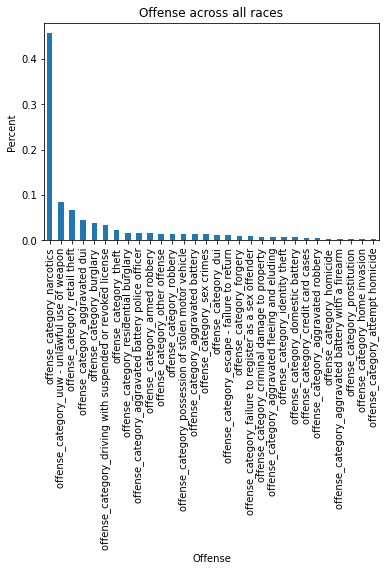

In [12]:
# looking at offense_category distribution for all races

# combining two series 
off_race_df = pd.concat([single_off_col.rename('offense'), single_race_col.rename('race')],
                        axis = 1)
val_counts = off_race_df['offense'].value_counts(normalize=
                                                   True).nlargest(30).plot(kind='bar')
plt.ylabel('Percent')
plt.xlabel('Offense')
plt.title('Offense across all races')

# saving top 20 offense_category across all races
top20allraces = list(off_race_df['offense'].value_counts().nlargest(20).index)

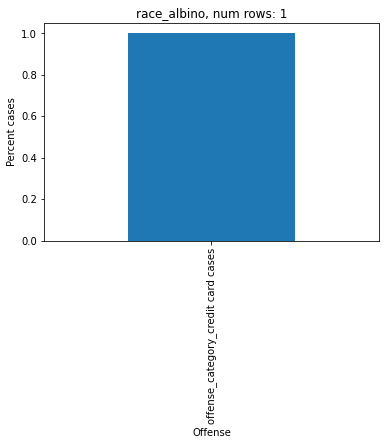

kl_test:  5.30349863544374
items in top 10 for this race that are not in top 20 items for all races:  {'offense_category_credit card cases'}


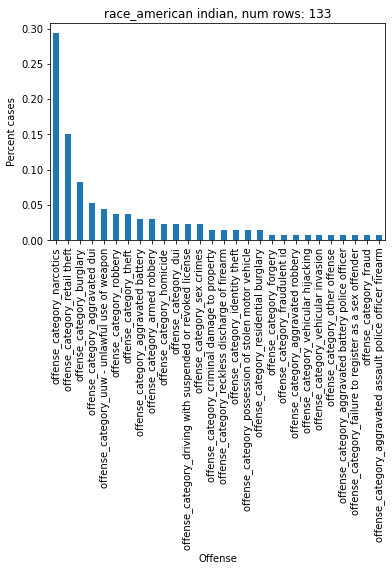

kl_test:  0.2993207886380759
items in top 10 for this race that are not in top 20 items for all races:  {'offense_category_homicide'}


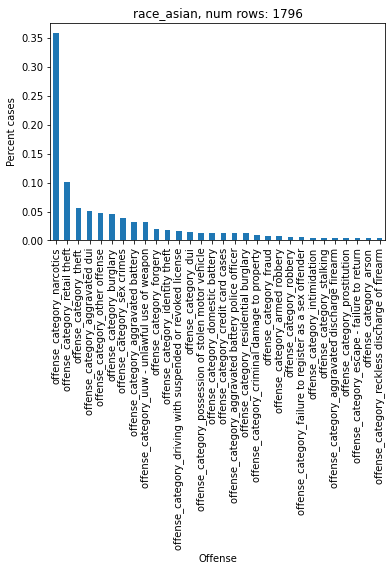

kl_test:  0.18615271057985555
items in top 10 for this race that are not in top 20 items for all races:  set()


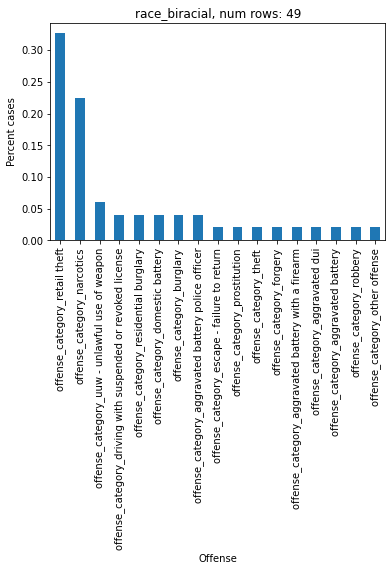

kl_test:  0.5960652819589437
items in top 10 for this race that are not in top 20 items for all races:  {'offense_category_domestic battery', 'offense_category_aggravated battery with a firearm'}


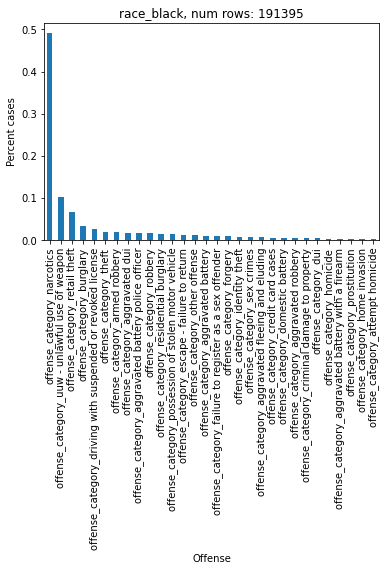

kl_test:  0.02132405743744574
items in top 10 for this race that are not in top 20 items for all races:  set()


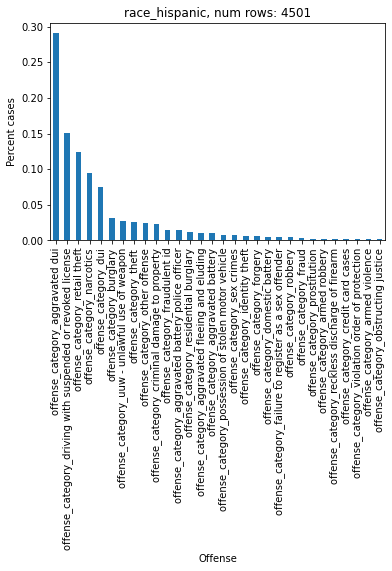

kl_test:  0.832861762774557
items in top 10 for this race that are not in top 20 items for all races:  set()


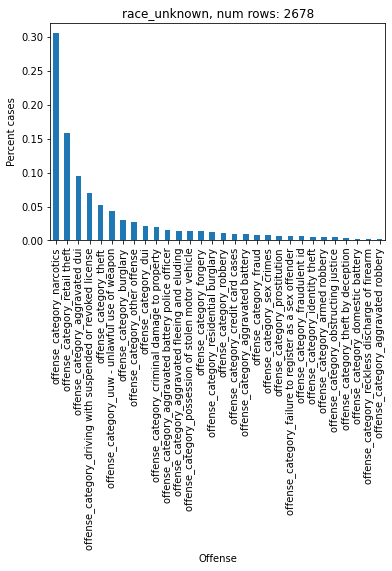

kl_test:  0.21036879846971263
items in top 10 for this race that are not in top 20 items for all races:  set()


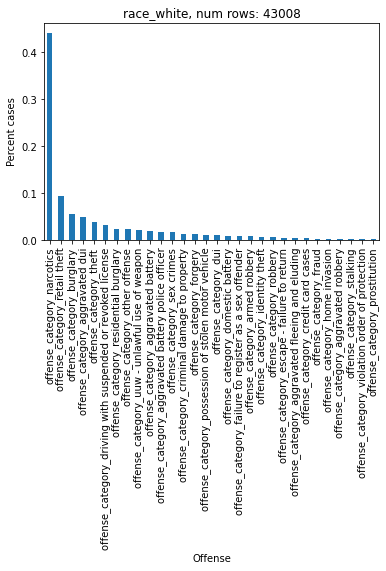

kl_test:  0.0725278748109411
items in top 10 for this race that are not in top 20 items for all races:  set()


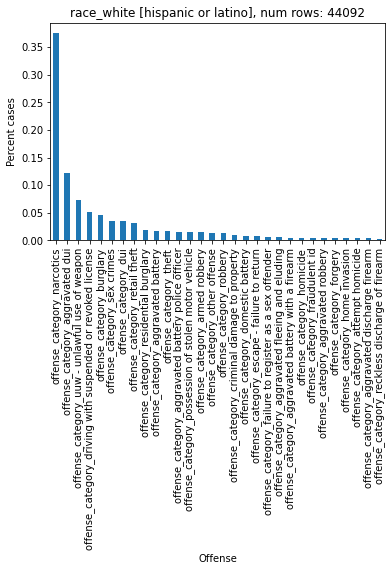

kl_test:  0.11231900155601396
items in top 10 for this race that are not in top 20 items for all races:  set()


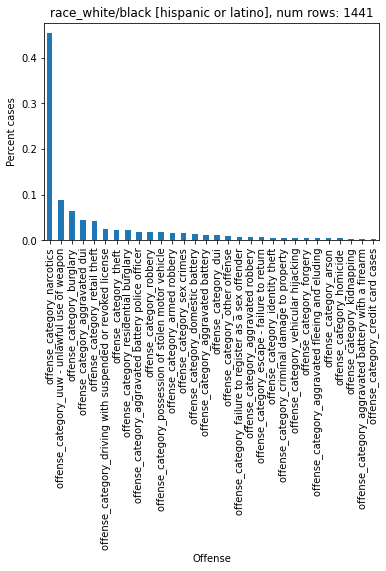

kl_test:  0.04913036050275245
items in top 10 for this race that are not in top 20 items for all races:  set()


In [13]:
# looking at offense distributions for each race
all_race_df = off_race_df

for col in race_cols:
    race_df = off_race_df[off_race_df['race'] == col]
    val_counts = race_df['offense'].value_counts(normalize=True).nlargest(30).plot(kind='bar')
    title = str(col) + ', num rows: ' + str(len(race_df))
    plt.xlabel('Offense')
    plt.title(title)
    plt.ylabel('Percent cases')
    plt.show()
    print('kl_test: ', kl_test(all_race_df, race_df, 'offense'))
    top10 = race_df['offense'].value_counts(normalize=True).nlargest(10).index
    
    # print categories in top 10 that are not in race top 20
    print('items in top 10 for this race that are not in top 20 items for all races: ',
          set(top10) - set(top20allraces))

### Repeating same process but looking at unit distribution. Nothing super noticeable here.

In [14]:
# check all cols are binary
unit_cols = check_allcols_are_binary(total_df, 'unit')

# all binary so undoing OHE
single_unit_col = undo_ohe_cols(total_df, unit_cols)

All columns binary, returning complete column list


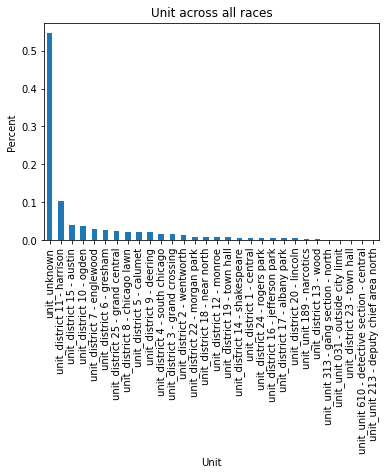

In [15]:
# looking at unit distribution for all races

# combining two series 
unit_race_df = pd.concat([single_unit_col.rename('unit'), 
                         single_race_col.rename('race')], axis = 1)
val_counts = unit_race_df['unit'].value_counts(normalize=
                                                   True).nlargest(30).plot(kind='bar')
plt.ylabel('Percent')
plt.xlabel('Unit')
plt.title('Unit across all races')

# saving top 20 unit across all races
top20allraces = list(unit_race_df['unit'].value_counts().nlargest(20).index)

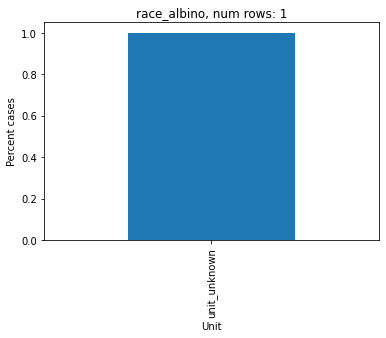

kl_test:  0.6033913320234576
items in top 10 for this race that are not in top 20 items for all races:  set()


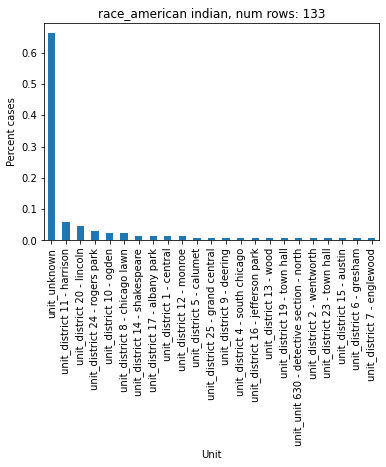

kl_test:  0.2677751886363217
items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 17 - albany park', 'unit_district 20 - lincoln'}


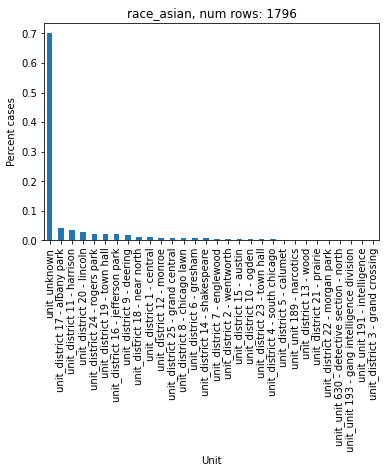

kl_test:  0.3083899703135631
items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 17 - albany park', 'unit_district 20 - lincoln', 'unit_district 16 - jefferson park'}


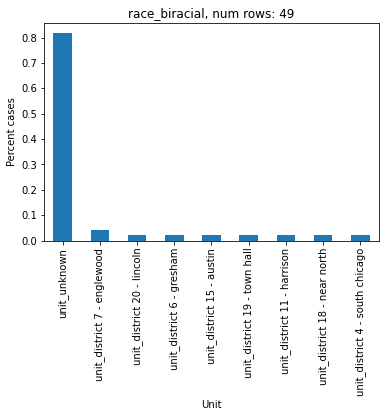

kl_test:  0.361930694638898
items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 20 - lincoln'}


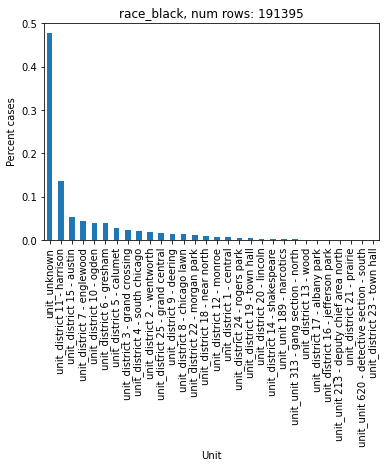

kl_test:  0.03193284360288405
items in top 10 for this race that are not in top 20 items for all races:  set()


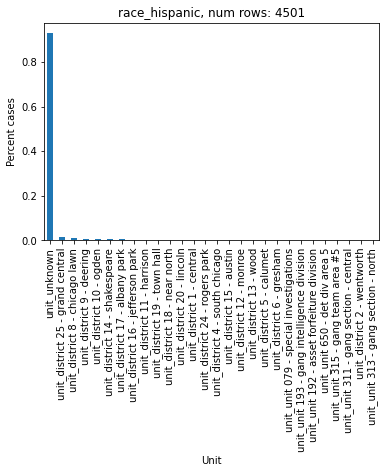

kl_test:  0.4180014399713881
items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 17 - albany park', 'unit_district 16 - jefferson park'}


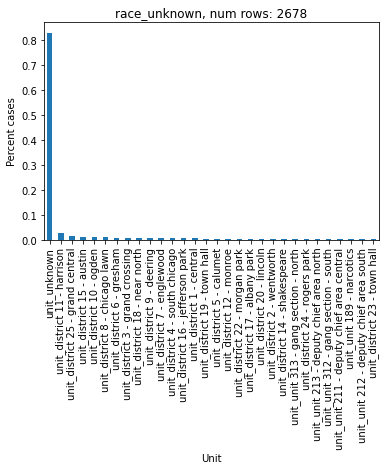

kl_test:  0.2087565555641273
items in top 10 for this race that are not in top 20 items for all races:  set()


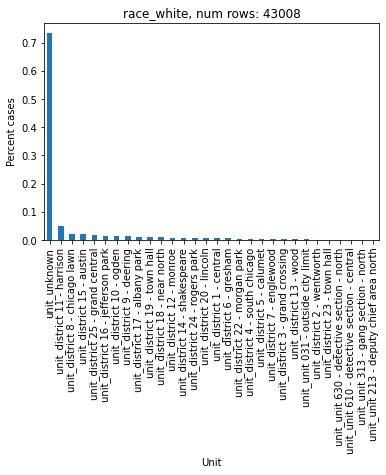

kl_test:  0.14211851224246552
items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 17 - albany park', 'unit_district 16 - jefferson park'}


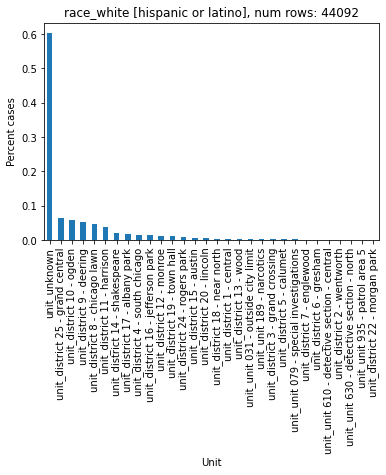

kl_test:  0.22284377853675608
items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 17 - albany park', 'unit_district 16 - jefferson park'}


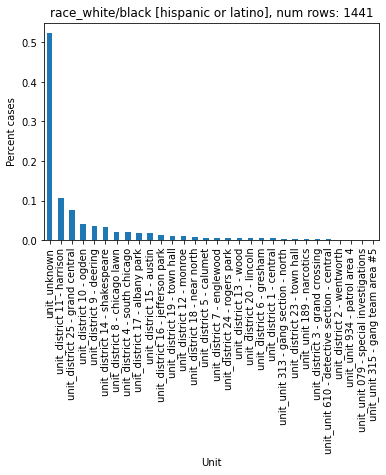

kl_test:  0.16811407795769814
items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 17 - albany park'}


In [17]:
# looking at unit distributions for each race
all_race_df = unit_race_df

for col in race_cols:
    race_df = unit_race_df[unit_race_df['race'] == col]
    val_counts = race_df['unit'].value_counts(normalize=True).nlargest(30).plot(kind='bar')
    title = str(col) + ', num rows: ' + str(len(race_df))
    plt.xlabel('Unit')
    plt.title(title)
    plt.ylabel('Percent cases')
    plt.show()
    print('kl_test: ', kl_test(all_race_df, race_df, 'unit'))
    top10 = race_df['unit'].value_counts(normalize=True).nlargest(10).index
    
    # print units in top 10 that are not in race top 20
    print('items in top 10 for this race that are not in top 20 items for all races: ',
          set(top10) - set(top20allraces))

### Repeating same process but looking at law_enforcement_agency distribution. See some pretty clear racial divides in neighborhoods and law_enforcement_agencys in the subpopulation graphs

In [13]:
# could be repeated for law_enforcement_agency, unit

# check all cols are binary
law_cols = check_allcols_are_binary(total_df, 'law')

# all binary so undoing OHE
single_law_col = undo_ohe_cols(total_df, law_cols)

All columns binary, returning complete column list


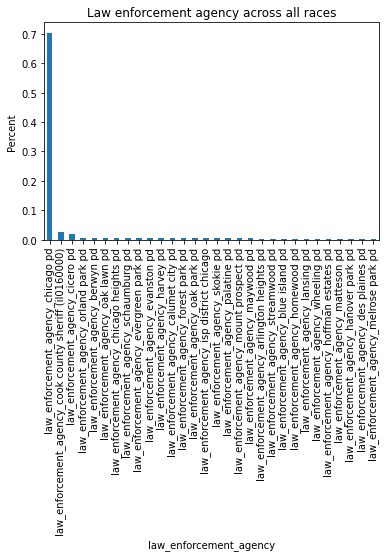

In [14]:
# looking at law_enforcement_agency distribution for all races

# combining two series 
law_race_df = pd.concat([single_law_col.rename('law_enforcement_agency'), 
                         single_race_col.rename('race')], axis = 1)
val_counts = law_race_df['law_enforcement_agency'].value_counts(normalize=
                                                   True).nlargest(30).plot(kind='bar')
plt.ylabel('Percent')
plt.xlabel('law_enforcement_agency')
plt.title('Law enforcement agency across all races')

# saving top 20 law_enfrocement_agency across all races
top20allraces = list(law_race_df['law_enforcement_agency'].value_counts().nlargest(20).index)

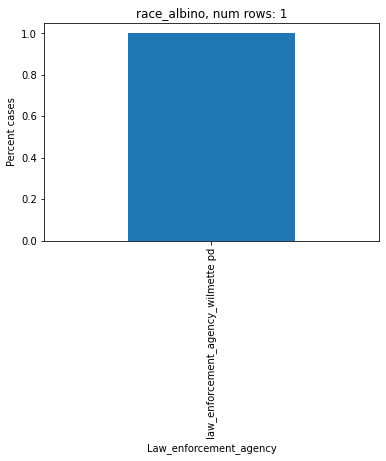

kl_test:  6.575570611778049
items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_wilmette pd'}


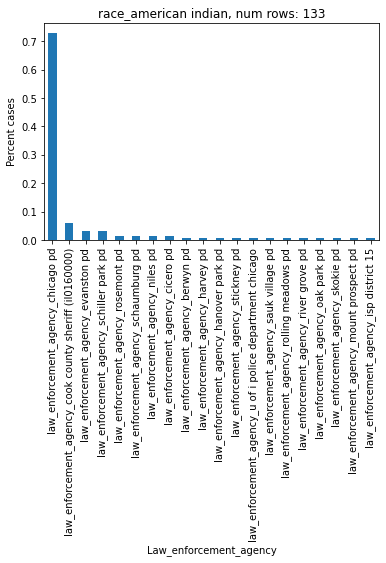

kl_test:  0.3822467243664565
items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_schiller park pd', 'law_enforcement_agency_rosemont pd', 'law_enforcement_agency_niles pd'}


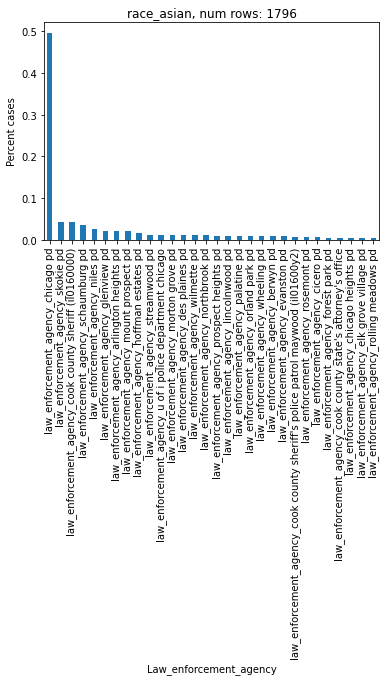

kl_test:  0.44832879038170353
items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_hoffman estates pd', 'law_enforcement_agency_streamwood pd', 'law_enforcement_agency_niles pd', 'law_enforcement_agency_glenview pd'}


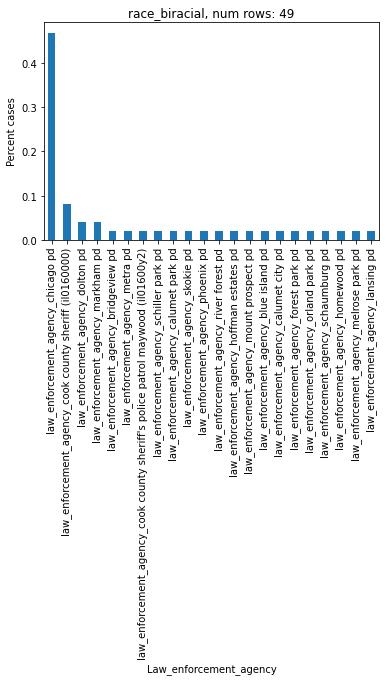

kl_test:  0.8983346995809111
items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_dolton pd', 'law_enforcement_agency_homewood pd', 'law_enforcement_agency_markham pd', 'law_enforcement_agency_melrose park pd'}


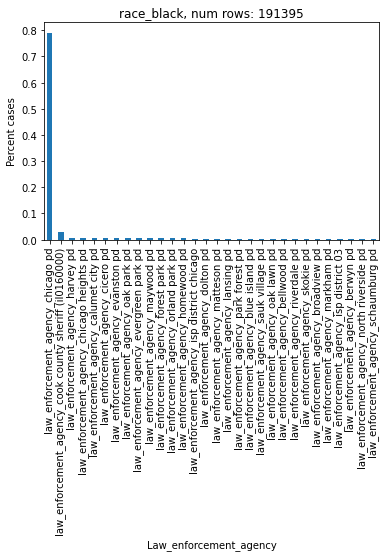

kl_test:  0.05082778813110558
items in top 10 for this race that are not in top 20 items for all races:  set()


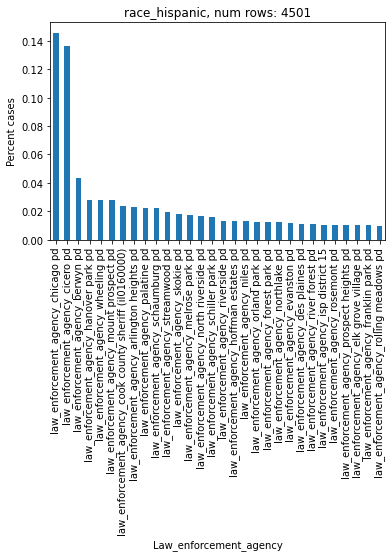

kl_test:  1.0362988366104031
items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_hanover park pd', 'law_enforcement_agency_wheeling pd'}


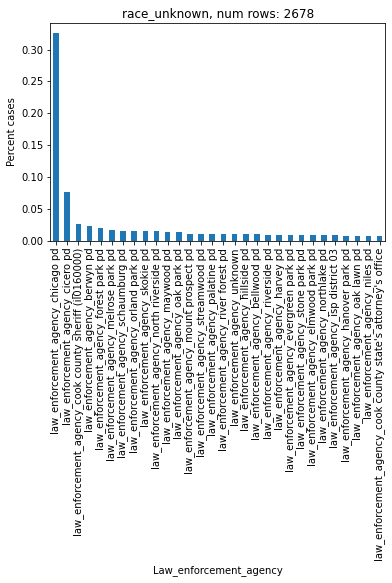

kl_test:  0.45563699768589183
items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_north riverside pd', 'law_enforcement_agency_melrose park pd'}


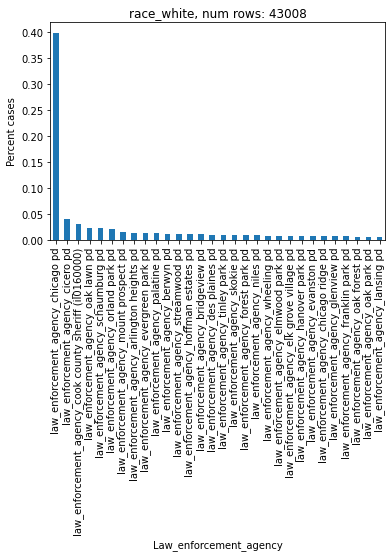

kl_test:  0.2953812487934171
items in top 10 for this race that are not in top 20 items for all races:  set()


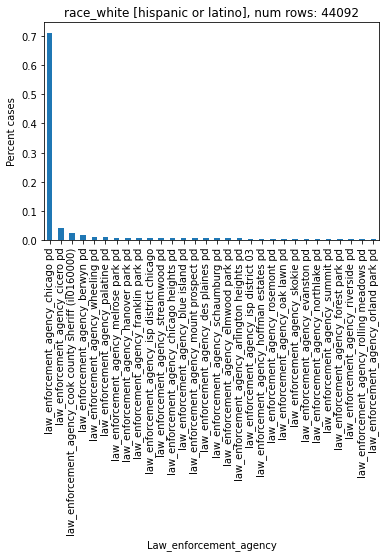

kl_test:  0.06499914946986557
items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_franklin park pd', 'law_enforcement_agency_hanover park pd', 'law_enforcement_agency_wheeling pd', 'law_enforcement_agency_melrose park pd'}


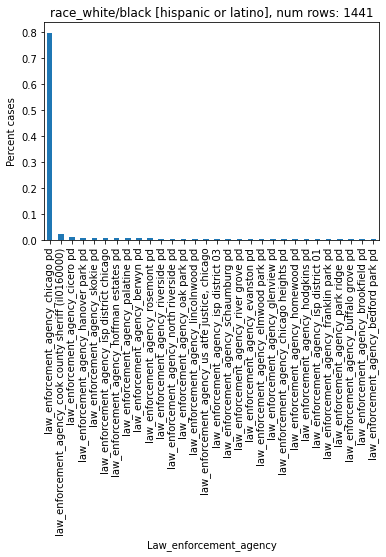

kl_test:  0.13433363063950005
items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_hoffman estates pd', 'law_enforcement_agency_hanover park pd', 'law_enforcement_agency_rosemont pd'}


In [15]:
# looking at law_enforcement_agency distributions for each race
all_race_df = law_race_df

for col in race_cols:
    race_df = law_race_df[law_race_df['race'] == col]
    val_counts = race_df['law_enforcement_agency'].value_counts(normalize=
                                                               True).nlargest(30).plot(kind=
                                                                                       'bar')
    title = str(col) + ', num rows: ' + str(len(race_df))
    plt.xlabel('Law_enforcement_agency')
    plt.title(title)
    plt.ylabel('Percent cases')
    plt.show()
    print('kl_test: ', kl_test(all_race_df, race_df, 'law_enforcement_agency'))
    top10 = race_df['law_enforcement_agency'].value_counts(normalize=True).nlargest(10).index
    
    # print agencies in top 10 that are not in race top 20
    print('items in top 10 for this race that are not in top 20 items for all races: ',
          set(top10) - set(top20allraces))

### Diving a little deeper to see correlations between certain neighborhoods and races. For example, we see 'law_enforcement_agency_wheeling pd' and 'law_enforcement_agency_hanover park pd' in 'race_hispanic' and 'race_white [hispanic or latino]'   distribution top 10, but not top 20 of all races.. Does it have a high correlation with hispanic? 

In [21]:
# one hot encoding law_enforcement_agency and race
dummy_lawrace = pd.get_dummies(law_race_df)
dummy_lawrace.head()

,law_enforcement_agency_law_enforcement_agency_alsip pd,law_enforcement_agency_law_enforcement_agency_amtrak national railroad passenger corp,law_enforcement_agency_law_enforcement_agency_arlington heights pd,law_enforcement_agency_law_enforcement_agency_barrington hills pd,law_enforcement_agency_law_enforcement_agency_barrington pd,law_enforcement_agency_law_enforcement_agency_bartlett pd,law_enforcement_agency_law_enforcement_agency_bedford park pd,law_enforcement_agency_law_enforcement_agency_bellwood pd,law_enforcement_agency_law_enforcement_agency_berkeley pd,law_enforcement_agency_law_enforcement_agency_berwyn pd,...,race_race_albino,race_race_american indian,race_race_asian,race_race_biracial,race_race_black,race_race_hispanic,race_race_unknown,race_race_white,race_race_white [hispanic or latino],race_race_white/black [hispanic or latino]
case_participant_id,,,,,,,,,,,,,,,,,,,,,
260122253823,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
272161011760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
864286527653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
882206007016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
882242005211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [23]:
# making abs value corr matrix so we can sort by "largest" regardless of correlation direction
corr = dummy_lawrace.corr()
corrabs = corr.abs()

In [24]:
corrabs['law_enforcement_agency_law_enforcement_agency_hanover park pd'].nlargest(7)

law_enforcement_agency_law_enforcement_agency_hanover park pd                    1.000000
law_enforcement_agency_law_enforcement_agency_chicago pd                         0.085999
race_race_hispanic                                                               0.056441
race_race_black                                                                  0.056430
race_race_white                                                                  0.027177
race_race_white [hispanic or latino]                                             0.024586
law_enforcement_agency_law_enforcement_agency_cook county sheriff (il0160000)    0.009293
Name: law_enforcement_agency_law_enforcement_agency_hanover park pd, dtype: float64

In [25]:
corrabs['law_enforcement_agency_law_enforcement_agency_wheeling pd'].nlargest(7)

law_enforcement_agency_law_enforcement_agency_wheeling pd                        1.000000
law_enforcement_agency_law_enforcement_agency_chicago pd                         0.090012
race_race_black                                                                  0.071723
race_race_hispanic                                                               0.052822
race_race_white [hispanic or latino]                                             0.042226
race_race_white                                                                  0.031891
law_enforcement_agency_law_enforcement_agency_cook county sheriff (il0160000)    0.009727
Name: law_enforcement_agency_law_enforcement_agency_wheeling pd, dtype: float64

# Looking into incident city vs law_enforcement relationships

In [16]:
# checking incident_city binary

# check all cols are binary
city_cols = check_allcols_are_binary(total_df, 'incident_city')

# all binary so undoing OHE
single_city_col = undo_ohe_cols(total_df, city_cols)

All columns binary, returning complete column list


In [19]:
# making combined df of law_enforcement_agency and incident_city
city_law_df = pd.concat([single_law_col.rename('law_enforcement_agency'), 
                         single_city_col.rename('incident_city')], axis = 1)

In [22]:
# ohe both columns
dummy_law_city = pd.get_dummies(city_law_df)
dummy_law_city.head()

,law_enforcement_agency_law_enforcement_agency_alsip pd,law_enforcement_agency_law_enforcement_agency_amtrak national railroad passenger corp,law_enforcement_agency_law_enforcement_agency_arlington heights pd,law_enforcement_agency_law_enforcement_agency_barrington hills pd,law_enforcement_agency_law_enforcement_agency_barrington pd,law_enforcement_agency_law_enforcement_agency_bartlett pd,law_enforcement_agency_law_enforcement_agency_bedford park pd,law_enforcement_agency_law_enforcement_agency_bellwood pd,law_enforcement_agency_law_enforcement_agency_berkeley pd,law_enforcement_agency_law_enforcement_agency_berwyn pd,...,incident_city_incident_city_wheaton,incident_city_incident_city_wheeling,incident_city_incident_city_willow spgs,incident_city_incident_city_willow springs,incident_city_incident_city_willowbrook,incident_city_incident_city_wilmette,incident_city_incident_city_winnetka,incident_city_incident_city_wood dale,incident_city_incident_city_woodstock,incident_city_incident_city_worth
case_participant_id,,,,,,,,,,,,,,,,,,,,,
260122253823,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272161011760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
864286527653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
882206007016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
882242005211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[Text(0.5, 0, 'law_enforcement_agency_law_enforcement_agency_alsip pd'),
 Text(22.5, 0, 'law_enforcement_agency_law_enforcement_agency_c p d area 3'),
 Text(44.5, 0, "law_enforcement_agency_law_enforcement_agency_cook county sheriff's crt srvcs - bridgeview (il01600y9)"),
 Text(66.5, 0, 'law_enforcement_agency_law_enforcement_agency_crestwood pd'),
 Text(88.5, 0, 'law_enforcement_agency_law_enforcement_agency_franklin park pd'),
 Text(110.5, 0, 'law_enforcement_agency_law_enforcement_agency_idoc pontiac'),
 Text(132.5, 0, 'law_enforcement_agency_law_enforcement_agency_isp district 04'),
 Text(154.5, 0, 'law_enforcement_agency_law_enforcement_agency_isp doo zone 1, elgin'),
 Text(176.5, 0, 'law_enforcement_agency_law_enforcement_agency_lynwood pd'),
 Text(198.5, 0, 'law_enforcement_agency_law_enforcement_agency_norridge pd'),
 Text(220.5, 0, 'law_enforcement_agency_law_enforcement_agency_phoenix pd'),
 Text(242.5, 0, 'law_enforcement_agency_law_enforcement_agency_south suburban college 

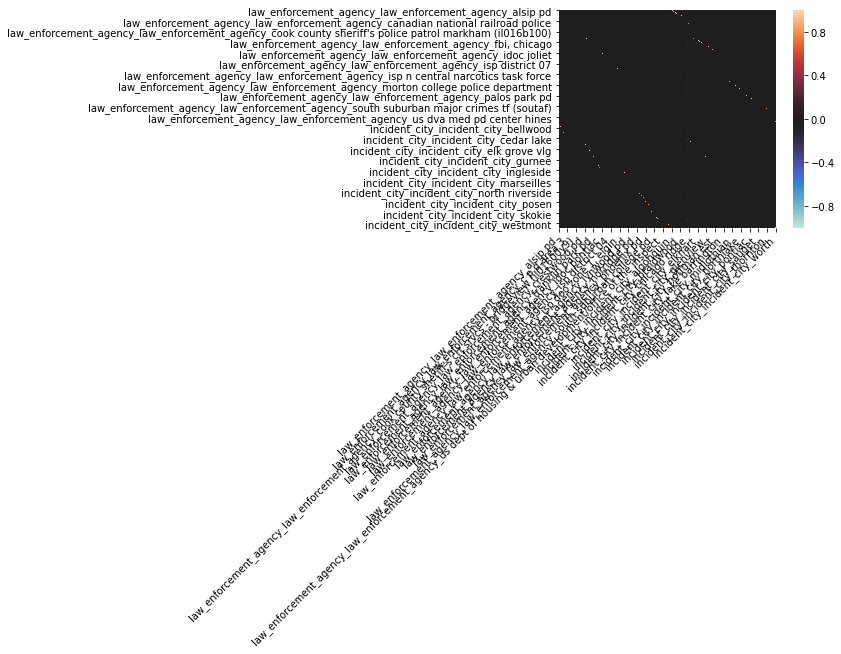

In [23]:
# trying heat map

corr = dummy_law_city.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

In [46]:
# looking just at row/cols with values above 0.9- reduces to dimension 100
m = (corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
raw = corr.loc[m, m]
raw

,law_enforcement_agency_law_enforcement_agency_bartlett pd,law_enforcement_agency_law_enforcement_agency_bedford park pd,law_enforcement_agency_law_enforcement_agency_berkeley pd,law_enforcement_agency_law_enforcement_agency_berwyn pd,law_enforcement_agency_law_enforcement_agency_blue island pd,law_enforcement_agency_law_enforcement_agency_brookfield pd,law_enforcement_agency_law_enforcement_agency_buffalo grove pd,law_enforcement_agency_law_enforcement_agency_burbank pd,law_enforcement_agency_law_enforcement_agency_calumet city pd,law_enforcement_agency_law_enforcement_agency_cicero pd,...,incident_city_incident_city_river forest,incident_city_incident_city_rosemont,incident_city_incident_city_sauk village,incident_city_incident_city_schaumburg,incident_city_incident_city_schiller park,incident_city_incident_city_streamwood,incident_city_incident_city_summit,incident_city_incident_city_tinley park,incident_city_incident_city_westchester,incident_city_incident_city_wheeling
law_enforcement_agency_law_enforcement_agency_bartlett pd,1.000000,-0.000933,-0.000680,-0.002276,-0.001717,-0.000920,-0.000779,-0.001195,-0.002062,-0.003856,...,-0.001433,-0.001372,-0.001489,-0.000717,-0.001163,0.000270,-0.001099,-0.001358,-0.000907,-0.001641
law_enforcement_agency_law_enforcement_agency_bedford park pd,-0.000933,1.000000,-0.000807,-0.002703,-0.002038,-0.001092,-0.000925,-0.001419,-0.002449,-0.004579,...,-0.001702,-0.001629,-0.001768,-0.002683,-0.001381,-0.002059,-0.001306,-0.001613,-0.001076,-0.001948
law_enforcement_agency_law_enforcement_agency_berkeley pd,-0.000680,-0.000807,1.000000,-0.001970,-0.001485,-0.000796,-0.000674,-0.001034,-0.001784,-0.003337,...,-0.001240,-0.001187,-0.001288,-0.000173,-0.001007,-0.001500,-0.000951,-0.001175,-0.000784,-0.001420
law_enforcement_agency_law_enforcement_agency_berwyn pd,-0.002276,-0.002703,-0.001970,1.000000,-0.004973,-0.002665,-0.002256,-0.003460,-0.005974,-0.011171,...,-0.004153,-0.003975,-0.004313,-0.006545,-0.003370,-0.005023,-0.003185,-0.003934,-0.002626,-0.004753
law_enforcement_agency_law_enforcement_agency_blue island pd,-0.001717,-0.002038,-0.001485,-0.004973,1.000000,-0.002010,-0.001701,-0.002609,-0.004505,-0.008424,...,-0.003131,-0.002997,-0.003252,-0.004936,-0.002541,-0.003788,-0.002402,-0.002967,-0.001980,-0.003584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
incident_city_incident_city_streamwood,0.000270,-0.002059,-0.001500,-0.005023,-0.003788,-0.002030,-0.001719,-0.002636,-0.004550,-0.008509,...,-0.003163,-0.003028,-0.003285,-0.004986,-0.002567,1.000000,-0.002426,-0.002997,-0.002000,-0.003621
incident_city_incident_city_summit,-0.001099,-0.001306,-0.000951,-0.003185,-0.002402,-0.001287,-0.001090,-0.001671,-0.002885,-0.004741,...,-0.002006,-0.001920,-0.002083,-0.003161,-0.001628,-0.002426,1.000000,-0.001900,-0.001268,-0.002296
incident_city_incident_city_tinley park,-0.001358,-0.001613,-0.001175,-0.003934,-0.002967,-0.001590,-0.001346,-0.002065,-0.003564,-0.006665,...,-0.002478,-0.002371,-0.002573,-0.003905,-0.002011,-0.002997,-0.001900,1.000000,-0.001567,-0.002836
incident_city_incident_city_westchester,-0.000907,-0.001076,-0.000784,-0.002626,-0.001980,-0.001061,-0.000898,-0.001378,-0.002379,-0.004448,...,-0.001654,-0.001583,-0.001717,-0.002606,-0.001342,-0.002000,-0.001268,-0.001567,1.000000,-0.001893


[Text(0.5, 0, 'law_enforcement_agency_law_enforcement_agency_bartlett pd'),
 Text(5.5, 0, 'law_enforcement_agency_law_enforcement_agency_brookfield pd'),
 Text(10.5, 0, 'law_enforcement_agency_law_enforcement_agency_countryside pd'),
 Text(15.5, 0, 'law_enforcement_agency_law_enforcement_agency_evanston pd'),
 Text(20.5, 0, 'law_enforcement_agency_law_enforcement_agency_hanover park pd'),
 Text(25.5, 0, 'law_enforcement_agency_law_enforcement_agency_kenilworth pd'),
 Text(30.5, 0, 'law_enforcement_agency_law_enforcement_agency_midlothian pd'),
 Text(35.5, 0, 'law_enforcement_agency_law_enforcement_agency_northlake pd'),
 Text(40.5, 0, 'law_enforcement_agency_law_enforcement_agency_phoenix pd'),
 Text(45.5, 0, 'law_enforcement_agency_law_enforcement_agency_sauk village pd'),
 Text(50.5, 0, 'law_enforcement_agency_law_enforcement_agency_tinley park pd'),
 Text(55.5, 0, 'incident_city_incident_city_berkeley'),
 Text(60.5, 0, 'incident_city_incident_city_burbank'),
 Text(65.5, 0, 'incident

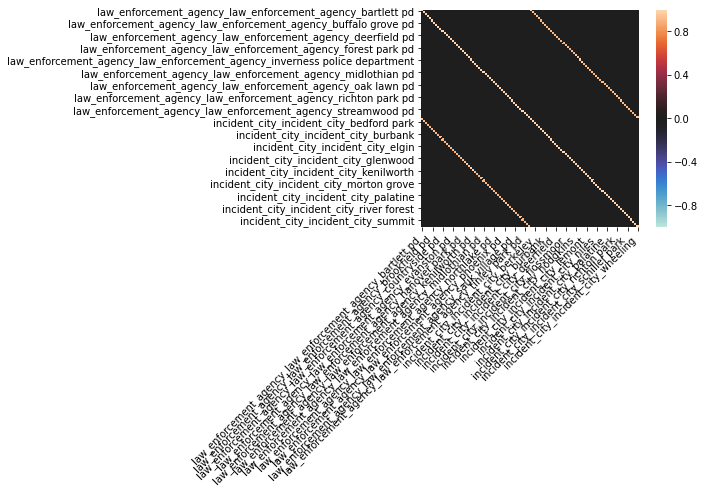

In [47]:
# trying heat map again with just 100 top correlated features 

ax = sns.heatmap(
    raw, 
    vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

### Above we can see some of the correlations (where they exist) between incident_city and law_enforcement_agency. Below some of the explict correlation values.

In [49]:
raw['incident_city_incident_city_bedford park'].nlargest(5)

incident_city_incident_city_bedford park                                     1.000000
law_enforcement_agency_law_enforcement_agency_bedford park pd                0.938504
law_enforcement_agency_law_enforcement_agency_summit pd                      0.001483
law_enforcement_agency_law_enforcement_agency_burbank pd                     0.000968
law_enforcement_agency_law_enforcement_agency_inverness police department   -0.000189
Name: incident_city_incident_city_bedford park, dtype: float64

In [50]:
raw['law_enforcement_agency_law_enforcement_agency_bartlett pd'].nlargest(5)

law_enforcement_agency_law_enforcement_agency_bartlett pd                    1.000000
incident_city_incident_city_bartlett                                         0.949413
incident_city_incident_city_hanover park                                     0.000633
incident_city_incident_city_streamwood                                       0.000270
law_enforcement_agency_law_enforcement_agency_inverness police department   -0.000156
Name: law_enforcement_agency_law_enforcement_agency_bartlett pd, dtype: float64

In [51]:
raw['law_enforcement_agency_law_enforcement_agency_streamwood pd'].nlargest(5)

law_enforcement_agency_law_enforcement_agency_streamwood pd    1.000000
incident_city_incident_city_streamwood                         0.946547
incident_city_incident_city_hanover park                       0.012641
incident_city_incident_city_schaumburg                         0.005578
incident_city_incident_city_bartlett                           0.002280
Name: law_enforcement_agency_law_enforcement_agency_streamwood pd, dtype: float64

In [54]:
# Looking at each row in complete OHE dataset to see if each one has a match
corrabs = corr.abs()
for col in corrabs.columns[:40]:
    print(corrabs[col].nlargest(2))

law_enforcement_agency_law_enforcement_agency_alsip pd    1.000000
incident_city_incident_city_alsip                         0.887403
Name: law_enforcement_agency_law_enforcement_agency_alsip pd, dtype: float64
law_enforcement_agency_law_enforcement_agency_amtrak national railroad passenger corp    1.000000
incident_city_incident_city_university park                                              0.075358
Name: law_enforcement_agency_law_enforcement_agency_amtrak national railroad passenger corp, dtype: float64
law_enforcement_agency_law_enforcement_agency_arlington heights pd    1.000000
incident_city_incident_city_arlington heights                         0.876563
Name: law_enforcement_agency_law_enforcement_agency_arlington heights pd, dtype: float64
law_enforcement_agency_law_enforcement_agency_barrington hills pd    1.000000
incident_city_incident_city_barrington hills                         0.516367
Name: law_enforcement_agency_law_enforcement_agency_barrington hills pd, dtype: fl

### We can see that there is usually, but not always a law_enforcement_agency correlated to incident_city. For example in the second case above ('law_enforcement_agency_amtrak national railroad passenger corp') there is no strongly correlated incident_city. 